In [ ]:
pip install numpy pandas tensorflow opencv-python scikit-learn matplotlib

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d ismailnasri20/driver-drowsiness-dataset-ddd

Dataset URL: https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd
License(s): unknown
 99% 2.56G/2.58G [00:24<00:00, 156MB/s]
100% 2.58G/2.58G [00:25<00:00, 111MB/s]


In [ ]:
import zipfile
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


with zipfile.ZipFile('/content/driver-drowsiness-dataset-ddd.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/driver-drowsiness-dataset-ddd')

print(os.listdir('/content/driver-drowsiness-dataset-ddd'))

['Driver Drowsiness Dataset (DDD)']


In [ ]:
# Function to load images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (64, 64))
            images.append(img)
    return np.array(images)

# Directories for drowsy and non-drowsy images
drowsy_folder = '/content/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Drowsy'
non_drowsy_folder = '/content/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy'

# Load images
drowsy_images = load_images_from_folder(drowsy_folder)
non_drowsy_images = load_images_from_folder(non_drowsy_folder)

print("Drowsy images shape:", drowsy_images.shape)
print("Non Drowsy images shape:", non_drowsy_images.shape)


Drowsy images shape: (22348, 64, 64, 3)
Non Drowsy images shape: (19445, 64, 64, 3)


In [ ]:
from sklearn.model_selection import train_test_split

drowsy_labels = np.ones(drowsy_images.shape[0])  # Drowsy = 1
non_drowsy_labels = np.zeros(non_drowsy_images.shape[0])  # Non Drowsy = 0

# Combine images and labels
X = np.concatenate([drowsy_images, non_drowsy_images], axis=0)
y = np.concatenate([drowsy_labels, non_drowsy_labels], axis=0)

# Shuffle the dataset
X, y = shuffle(X, y, random_state=42)

# Normalize the images
X = X / 255.0

# Define your splits
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15  # val_ratio + test_ratio = 0.3

# Compute split indices
N = X.shape[0]
train_end = int(train_ratio * N)
val_end = train_end + int(val_ratio * N)

# Split the dataset using direct indexing
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

# You now have X_train, y_train, X_val, y_val, X_test, y_test
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (29255, 64, 64, 3), (29255,)
Validation set: (6268, 64, 64, 3), (6268,)
Test set: (6270, 64, 64, 3), (6270,)


In [ ]:
print(f"X dtype: {X.dtype}, min: {X.min()}, max: {X.max()}")
print(f"Sample image dtype: {X[0].dtype}, min: {X[0].min()}, max: {X[0].max()}")

X dtype: float64, min: 0.0, max: 1.0
Sample image dtype: float64, min: 0.03529411764705882, max: 1.0


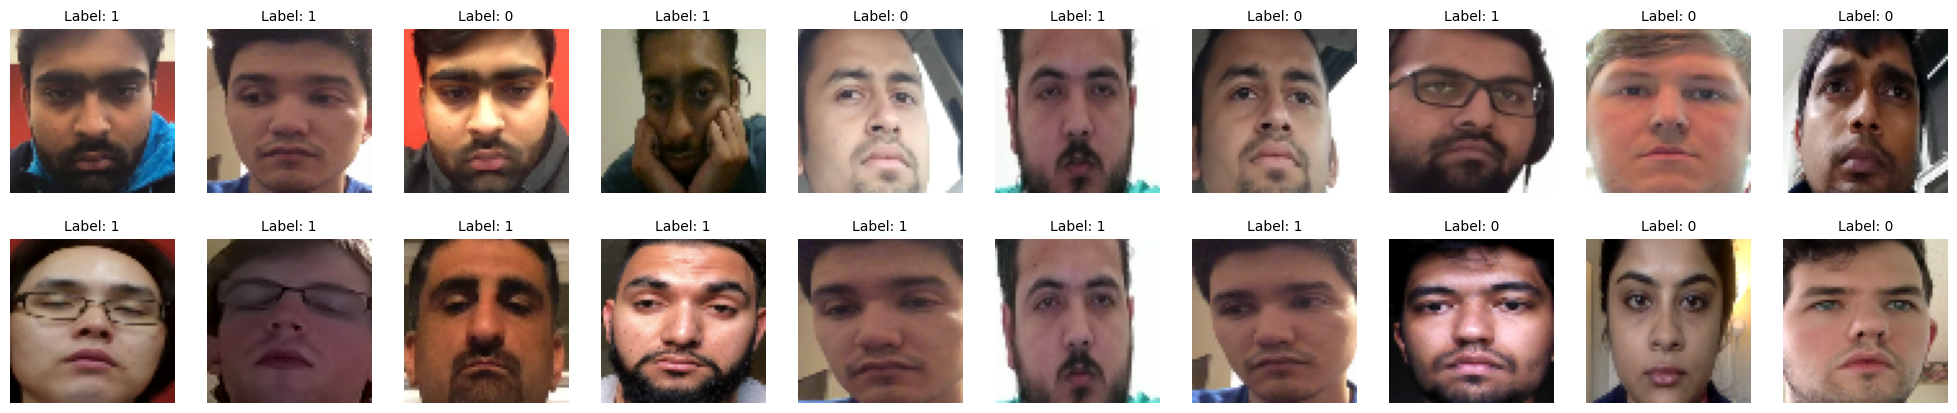

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to display an image
def imshow(img, title=None):
    if img.shape[-1] == 3:
        img = img[..., ::-1]
    plt.imshow(img)
    if title:
        plt.title(title, fontsize=10)
    plt.axis('off')


num_images = 20
indices = np.random.choice(range(X.shape[0]), num_images, replace=False)

fig = plt.figure(figsize=(25, 5))
for i, idx in enumerate(indices):
    ax = fig.add_subplot(2, 10, i + 1, xticks=[], yticks=[])
    imshow(X[idx], title=f"Label: {int(y[idx])}")
plt.show()

In [ ]:
class MyDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_array = self.image_paths[idx]
        if image_array.dtype != np.uint8:
            image_array = (image_array * 255).astype(np.uint8)

        image = Image.fromarray(image_array)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Define data augmentation and normalization transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset instances
train_dataset = MyDataset(image_paths=X_train, labels=y_train, transform=transform)
val_dataset = MyDataset(image_paths=X_val, labels=y_val, transform=transform)
test_dataset = MyDataset(image_paths=X_test, labels=y_test, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Convolutional layers and pooling layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 1)  # Output a single value for binary classification
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(nn.ReLU()(self.conv1(x)))
        x = self.pool2(nn.ReLU()(self.conv2(x)))
        x = self.pool3(nn.ReLU()(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)  # Flatten the data
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))  # Sigmoid activation for binary classification
        return x

# Initialize the model
model = CNNModel()

In [ ]:
model = model.cuda()

Epoch [1/15], Train Loss: 0.0875, Val Loss: 0.0047
Validation loss improved. Saving model at epoch 1.
Epoch [2/15], Train Loss: 0.0083, Val Loss: 0.0020
Validation loss improved. Saving model at epoch 2.
Epoch [3/15], Train Loss: 0.0047, Val Loss: 0.0015
Validation loss improved. Saving model at epoch 3.
Epoch [4/15], Train Loss: 0.0028, Val Loss: 0.0005
Validation loss improved. Saving model at epoch 4.
Epoch [5/15], Train Loss: 0.0021, Val Loss: 0.0010
No improvement for 1 epoch(s).
Epoch [6/15], Train Loss: 0.0016, Val Loss: 0.0002
Validation loss improved. Saving model at epoch 6.
Epoch [7/15], Train Loss: 0.0002, Val Loss: 0.0001
Validation loss improved. Saving model at epoch 7.
Epoch [8/15], Train Loss: 0.0014, Val Loss: 0.0002
No improvement for 1 epoch(s).
Epoch [9/15], Train Loss: 0.0009, Val Loss: 0.0003
No improvement for 2 epoch(s).
Early stopping triggered after 9 epochs.


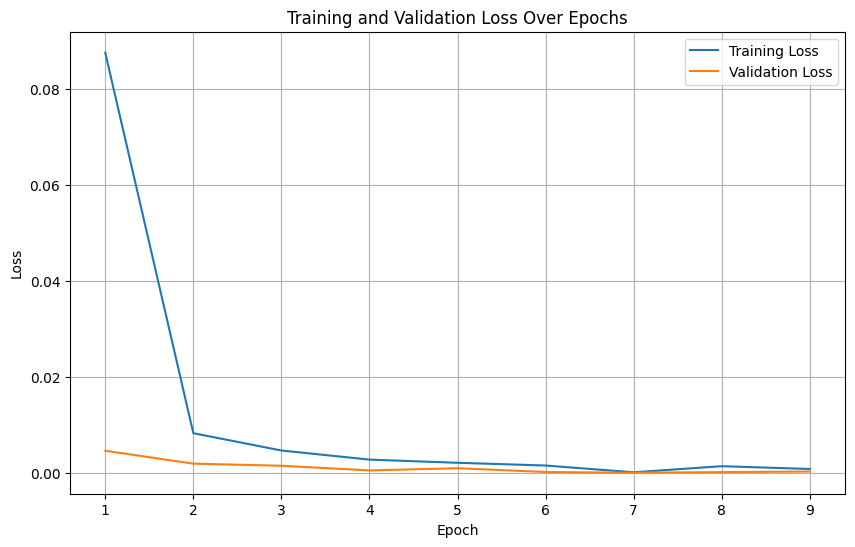

In [ ]:
import matplotlib.pyplot as plt

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy loss for binary classification
#L2 regularization test
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Training loop with early stopping
num_epochs = 15  # Maximum number of epochs
patience = 2  # Tolerance for early stopping
best_val_loss = float('inf')  # Initialize best validation loss
epochs_no_improve = 0  # Counter for early stopping

# Lists to store losses for plotting
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()  # Move to GPU
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels.float())  # Calculate loss

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():  # No gradients during validation
        for images, labels in val_loader:
            images, labels = images.cuda(), labels.cuda()  # Move to GPU

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())  # Calculate validation loss
            val_loss += loss.item()

    # Calculate average losses
    train_loss = running_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)

    # Store losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Validation loss improved. Saving model at epoch {epoch+1}.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    # Early stopping check
    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

# Plotting the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Testing the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        predicted = (outputs.squeeze() > 0.5).float()  # Use 0.5 as the classification threshold
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total}%')

Accuracy: 99.98404594767071%


In [ ]:
# Testing the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        predicted = (outputs.squeeze() > 0.5).float()  # Use 0.5 as the classification threshold
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total}%')

Accuracy: 99.98405103668262%


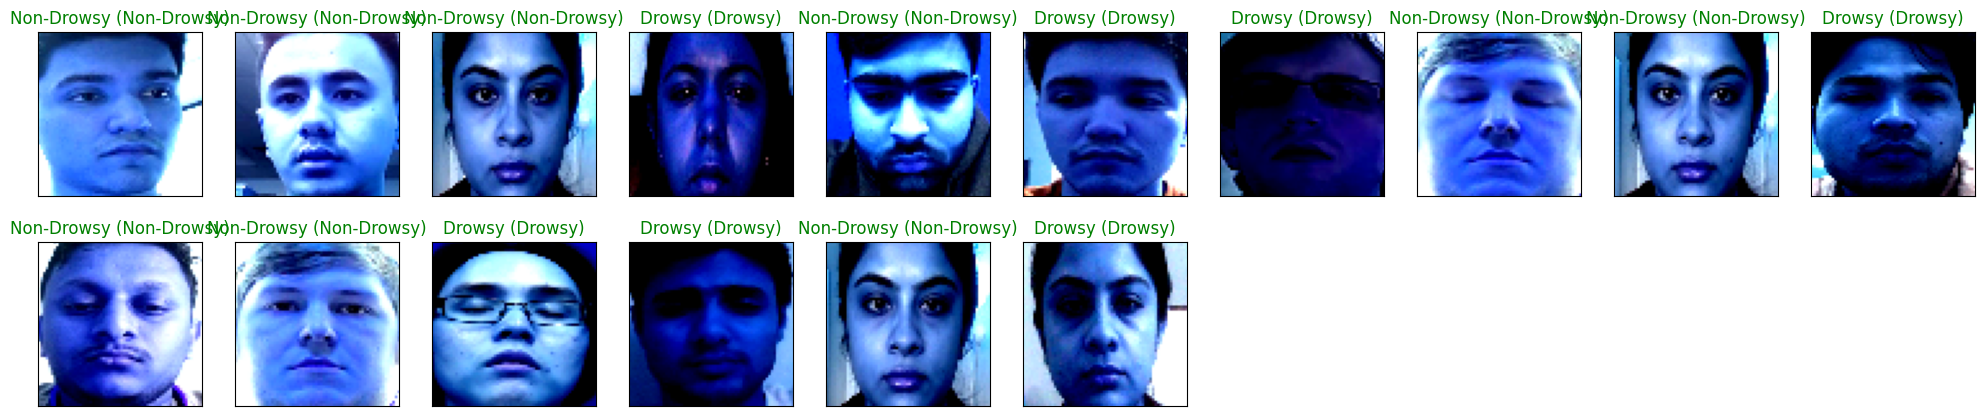

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

classes = ["Non-Drowsy", "Drowsy"]

dataiter = iter(test_loader)
images, labels = next(dataiter)

if torch.cuda.is_available():
    images, labels = images.cuda(), labels.cuda()

output = model(images)

preds = (output.squeeze() > 0.5).long()

fig = plt.figure(figsize=(25, 5))
for idx in np.arange(min(20, len(images))):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])

    img = images[idx].cpu().numpy() if torch.cuda.is_available() else images[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = img / 2 + 0.5
    img = np.clip(img, 0, 1)
    plt.imshow(img)

    ax.set_title(
        f"{classes[int(preds[idx])]} ({classes[int(labels[idx])]})",
        color=("green" if preds[idx] == labels[idx] else "red")
    )
plt.show()

## Check whether there are problems from the high accuracy


### Check category distribution:

In [ ]:
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 19445, 1.0: 22348}


### Check that the category distribution is consistent:

In [ ]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

print("Training set distribution:", np.bincount(y_train))
print("Test set distribution:", np.bincount(y_test))

Training set distribution: [13594 15661]
Test set distribution: [2939 3331]


### Check the number of parameters of the model:

In [ ]:
print("Number of model parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Number of model parameters: 4288577


### Classfication Report & Confusion Matrix:

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()

        outputs = model(images)
        preds = (outputs.squeeze() > 0.5).long()
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())


all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)


print("Classification Report:")
print(classification_report(all_labels, all_preds))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2939
         1.0       1.00      1.00      1.00      3331

    accuracy                           1.00      6270
   macro avg       1.00      1.00      1.00      6270
weighted avg       1.00      1.00      1.00      6270

Confusion Matrix:
[[2939    0]
 [   1 3330]]


### Check if the training set and the test set have overlapping samples:

In [ ]:
train_hashes = {hash(tuple(row.flatten())) for row in X_train}
test_hashes = {hash(tuple(row.flatten())) for row in X_test}
overlap = train_hashes & test_hashes
print(f"Number of overlapping samples: {len(overlap)}")

Number of overlapping samples: 0


In [ ]:
from sklearn.metrics import classification_report

model.eval()  # 切换到评估模式
train_preds = []
train_labels = []

with torch.no_grad():  # 关闭梯度计算
    for images, labels in train_loader:
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()

        # 模型预测
        outputs = model(images)
        preds = (outputs.squeeze() > 0.5).long()  # 二分类阈值
        train_preds.append(preds.cpu().numpy())
        train_labels.append(labels.cpu().numpy())

# 将所有批次的预测和标签拼接
train_preds = np.concatenate(train_preds)
train_labels = np.concatenate(train_labels)

# 输出训练集分类报告
print("Training Set Classification Report:")
print(classification_report(train_labels, train_preds))

Training Set Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13594
         1.0       1.00      1.00      1.00     15661

    accuracy                           1.00     29255
   macro avg       1.00      1.00      1.00     29255
weighted avg       1.00      1.00      1.00     29255

